# (Amortized) distance learning directly using a feedforward network
- define prior $p(\theta)$ and sample
- produce simulations $x \sim p(x|\theta)$
- append observations $x_o$
- compute $d(\theta_i, x_j) := d(x(\theta_i),x_j), x_j \in \{X_{simulated}, X_{observed}\}$
- train network $NN_{\phi}(\theta_i, x_j) \rightarrow d(x(\theta_i),x_j)$
- at inference time, define generalized likelihood $e^{-\beta \times NN_{\phi}(\theta, x_o)}$, and sample GBI posterior

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import matplotlib.pyplot as plt
from sbi.utils import BoxUniform
from sbi.inference import MCMCPosterior, SNPE, RejectionPosterior
from gbi import GBI, distances
import gbi.utils as gbi_utils
import numpy as np
from torch import Tensor, nn
import torch
# import sbibm

In [9]:
# def merge_simulated_observed_xs(x, x_obs=None):
#     if x_obs==None:
#         # no observations, just take simulations as observations
#         x_target = x
#     else:
#         # Make appended x tensor that includes simulations and observations
#         x_target = torch.concat([x, x_obs], dim=0)
#     return x_target


# def compute_distances(x, x_target, dist_func):
#     # Precompute distances, in shape of [num_theta, num_x], with num_x >= num_theta
#     return torch.hstack([dist_func(x.unsqueeze(1), x_t).unsqueeze(1) for x_t in x_target])


# def compute_index_pairs(dist_precomputed, n_lowest=None):
#     n_theta, n_x_target = dist_precomputed.shape
#     if n_lowest==None:
#         # Not subselecting, return full index list
#         idx_train = Tensor(np.indices((n_theta,n_x_target)).reshape((2,-1)).T)
#     else:
#         # Subselect n lowest distances for train (doesn't work well)
#         idx_train = torch.vstack([torch.topk(dist_precomputed, n_lowest, 0, largest=False)[1].T.reshape(-1),
#               torch.arange(n_x_target).repeat((n_lowest,1)).T.reshape(-1)
#              ]).T
#     return idx_train.to(int)

# def train(distance_net, idx_train, theta, x_target, dist_precomputed, training_batch_size=100, n_epochs=100, validation_fraction=0.1, print_every_n=10):
#     # Define loss and optimizer
#     nn_loss = nn.MSELoss()
#     optimizer = optim.Adam(distance_net.parameters())
    
#     # Splitting train and validation set
#     dataset = TensorDataset(idx_train)
#     train_set, val_set = torch.utils.data.random_split(dataset, (Tensor([1-validation_fraction, validation_fraction])*len(dataset)).to(int))
#     dataloader = DataLoader(train_set, batch_size=training_batch_size, shuffle=True)
    
#     # Get validation set once
#     theta_val, x_val, dist_val = idx_to_data(val_set[:], theta, x_target, dist_precomputed)

#     train_losses, val_losses = [], []
#     for e in range(n_epochs):
#         for i_b, idx_batch in enumerate(dataloader):
#             optimizer.zero_grad()

#             # load batch of theta, x, and pre-computed distances
#             theta_batch, x_batch, dist_batch = idx_to_data(idx_batch, theta, x_target, dist_precomputed)

#             # forward pass for distances
#             dist_pred = distance_net(theta_batch, x_batch).squeeze()

#             # training loss
#             l = nn_loss(dist_batch, dist_pred)
#             l.backward()
#             optimizer.step()        
#             train_losses.append(l.detach())

#         # compute validation loss    
#         dist_pred = distance_net(theta_val, x_val).squeeze()
#         l_val = nn_loss(dist_val, dist_pred)
#         val_losses.append([i_b*e, l_val.detach()])

#         if e%print_every_n==0:
#             print(f"{e}: {l}")

#     train_losses = torch.Tensor(train_losses)
#     val_losses = torch.Tensor(val_losses)

#     return distance_net, train_losses, val_losses

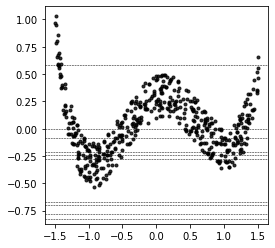

In [10]:
# uniform noise task
def simulator(theta, poly_coeffs, noise_width = 1):
    # 1D 4-th order polynomial simulator with uniform noise    
    noise = torch.rand(theta.shape[0]) * noise_width - noise_width/2
    return (torch.hstack([(.8*(theta+0.25))**i for i in range(5)]) * poly_coeffs).sum(1, keepdim=True) + noise.unsqueeze(1)


# poly_coeffs = torch.randn((5,))
poly_coeffs = Tensor([ 0.1627,  0.9073, -1.2197, -1.4639,  1.4381])


n_samples = 500
noise_width = 0.4
torch.manual_seed(0)

# define distance function
dist = distances.mse_dist

# run simulations
prior = BoxUniform(-1.5*torch.ones(1), 1.5*torch.ones(1))
theta = prior.sample((n_samples,))
x = simulator(theta, poly_coeffs, noise_width)

# x_obs = torch.arange(-1,1.2,.2).unsqueeze(1)
x_obs = torch.rand(10).unsqueeze(1) * 2. - 1.
x_target = gbi_utils.concatenate_xs(x, x_obs)

x_test = torch.rand(10).unsqueeze(1) * 2. - 1.

plt.figure(figsize=(4,4))
plt.plot(theta, x, '.k', alpha=0.8)
[plt.axhline(x, lw=0.5, color='k', ls='--') for x in x_obs];

0: 0.006611797958612442


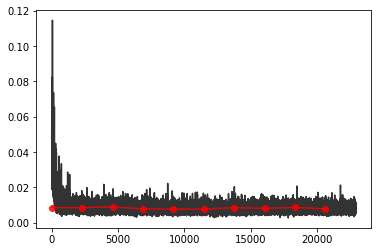

In [11]:
gbi = GBI.GBInference(prior, distances.mse_dist)
gbi.append_simulations(theta, x, x_target)
# gbi.initialize_distance_estimator(5, 64, 'resnet', net_kwargs={'dropout_prob':0.1})
gbi.initialize_distance_estimator(3, 32, 'MLP', net_kwargs={'activate_output': True, 'activation':nn.ReLU})
distance_net = gbi.train(n_epochs=10)

In [14]:
# train NPE
inference = SNPE(prior, density_estimator='nsf')
density_estimator = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 112 epochs.

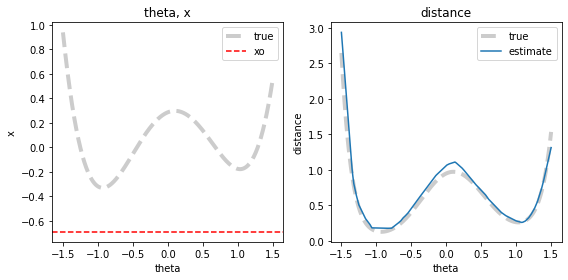

In [15]:
# evaluation
x_o = x_test[3] # 3

theta_grid = torch.linspace(-1.5,1.5,3001).unsqueeze(1)
x_grid = simulator(theta_grid, poly_coeffs, 0)

dist_grid = dist(x_grid.unsqueeze(1), x_o)
dist_pred = gbi.distance_net(theta_grid, x_o.repeat(theta_grid.shape))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(theta_grid, x_grid, 'k--', lw=4, alpha=0.2, label='true')
plt.axhline(x_o.squeeze(), color='r', ls='--', label='xo')
plt.title('theta, x'); plt.legend()
plt.xlabel('theta');plt.ylabel('x');

plt.subplot(1,2,2)
plt.plot(theta_grid, dist_grid, 'k--', lw=4, alpha=0.2, label='true')
plt.plot(theta_grid, dist_pred.detach(), '-', alpha=1, label='estimate')
plt.title('distance');plt.legend()
plt.xlabel('theta');plt.ylabel('distance');
plt.tight_layout()

In [17]:
n_posterior_samples = 200
beta = 50

gbi_posterior = gbi.build_posterior(MCMCPosterior, beta=beta)
npe_posterior = inference.build_posterior(density_estimator)

# gbi_potential = GBIPotential(gbi.prior, gbi.build_amortized_GLL(), x_o, beta)
# gbi_potential.set_x(x_o)
# gbi_potential.set_beta(beta)

# gbi_sampler = MCMCPosterior(gbi_potential, prior)
# gbi_sampler.set_default_x(x_o) # this doesn't kick in until sample() is called
# gbi_sampler.potential_fn.set_x(torch.tensor([[0.0011]])) # or just put x_o in sample directly...actually this doesn't work because it doesn't change default_x
# gbi_posterior.potential_fn.set_beta(beta)

# gbi samples
gbi_samples = gbi_posterior.sample((n_posterior_samples,), x=x_o) # or set x=x_obs


# npe samples
npe_samples = npe_posterior.sample((n_posterior_samples,), x=x_o)

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

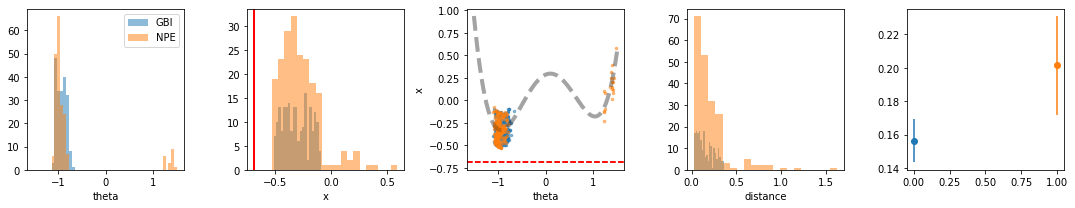

In [18]:
plt.figure(figsize=(15,3))

for i_p, posterior_samples in enumerate([gbi_samples, npe_samples]):
    plt.subplot(1,5,1)
    plt.hist(posterior_samples.numpy().squeeze(), np.linspace(-1.5,1.5,50), alpha=0.5);
    plt.xlabel('theta')

    post_pred = simulator(posterior_samples, poly_coeffs, noise_width)
    plt.subplot(1,5,2)
    plt.hist(post_pred.numpy().squeeze(), 20, alpha=0.5);
    plt.axvline(x_o.squeeze(), color='r', lw=2)
    plt.xlabel('x')
    
    plt.subplot(1,5,3)
    plt.plot(posterior_samples.squeeze(), post_pred.squeeze(), '.', alpha=0.5, ms=5)
    plt.plot(theta_grid, x_grid, 'k--', lw=4, alpha=0.2, label='true')
    plt.axhline(x_o.squeeze(), color='r', ls='--', label='xo')
    plt.xlabel('theta'); plt.ylabel('x'); 

    post_pred_dist = dist(post_pred.unsqueeze(1), x_o)
    plt.subplot(1,5,4)
    plt.hist(post_pred_dist.numpy().squeeze(), 20, alpha=0.5);
    # plt.axvline(x_o.squeeze(), color='r', lw=2)
    plt.xlabel('distance')
    
    plt.subplot(1,5,5)
    plt.errorbar(i_p, post_pred_dist.mean(), post_pred_dist.std()/np.sqrt(post_pred_dist.shape[0])*2, fmt='o') # mean +/- 2 sem

# theta_grid[np.abs(x_grid-x_o)<=(noise_width/2)];
plt.subplot(1,5,1)
plt.legend(['GBI', 'NPE'])
plt.tight_layout()

In [21]:
beta = 50.
n_posterior_samples = 100

gbi_posterior.potential_fn.set_beta(beta)

all_posterior_samples = []
for i_x, x_o in enumerate(x_test):
    print(i_x, x_o)
    # GBI samples
    gbi_samples = gbi_posterior.sample((n_posterior_samples,), x=x_o)
    # NPE samples
    npe_samples = npe_posterior.sample((n_posterior_samples,), x=x_o)    
    all_posterior_samples.append([gbi_samples, npe_samples])

0 tensor([0.1693])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

1 tensor([0.1660])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

2 tensor([0.5071])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

3 tensor([-0.6889])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

4 tensor([-0.0706])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

5 tensor([0.5593])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

6 tensor([0.8650])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

7 tensor([-0.0729])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

8 tensor([-0.5786])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

9 tensor([0.2875])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

/home/rdgao/miniconda3/envs/gbi/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


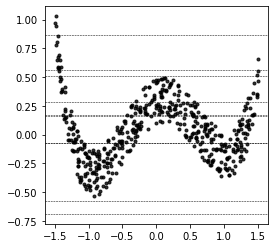

In [22]:
plt.figure(figsize=(4,4))
plt.plot(theta, x, '.k', alpha=0.8)
[plt.axhline(x, lw=0.5, color='k', ls='--') for x in x_test];

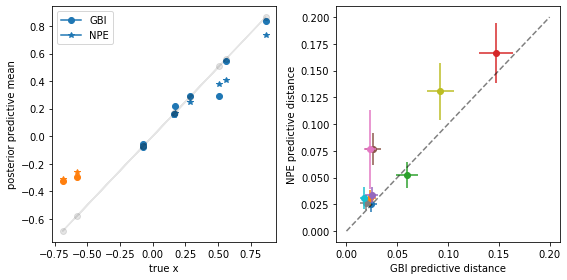

In [23]:
plt.figure(figsize=(8,4))
for i_p, pp in enumerate(all_posterior_samples):
    post_pred_dist = []
    for i_q, posterior_samples in enumerate(pp):
        plt.subplot(1,2,1)
        post_pred = simulator(posterior_samples, poly_coeffs, noise_width)
        c = 0 if (x_test[i_p] > x.min()) & (x_test[i_p] < x.max()) else 1
        plt.plot(x_test[i_p], post_pred.mean(), f'C{c}', marker='o' if i_q==0 else '*')        
        post_pred_dist.append(dist(post_pred.unsqueeze(1), x_test[i_p]))
        
    plt.subplot(1,2,2)
    plt.plot(post_pred_dist[0].mean(), post_pred_dist[1].mean(), f'oC{i_p}')
    plt.errorbar(post_pred_dist[0].mean(), post_pred_dist[1].mean(), xerr=post_pred_dist[0].std()/(n_posterior_samples**0.5)*2, yerr=post_pred_dist[1].std()/(n_posterior_samples**0.5)*2, color=f'C{i_p}')

plt.subplot(1,2,1)
plt.legend(['GBI', 'NPE'])
plt.plot(x_test, x_test, '-ok', alpha=0.1)
plt.xlabel('true x'); plt.ylabel('posterior predictive mean')

plt.subplot(1,2,2)
plt.plot([0,0.2], [0,0.2], 'k--', alpha=0.5)
plt.xlabel('GBI predictive distance'); plt.ylabel('NPE predictive distance');
plt.tight_layout()

In [6]:
n_lowest = None
dist_func = distances.mse_dist
x_target = merge_simulated_observed_xs(x, x_obs)
dist_precomputed = compute_distances(x, x_target, dist_func)
idx_train = get_index_pairs(dist_precomputed, n_lowest)


In [10]:
num_layers = 5
num_hidden = 64

distance_net = DistanceEstimator(theta.shape[1], x.shape[1], num_layers, num_hidden, net_type='MLP')
distance_net, train_losses, val_losses = train(distance_net, idx_train, theta, x_target, dist_precomputed)

0: 0.009767726995050907
10: 0.01043051015585661
20: 0.006621608044952154
30: 0.008642148226499557
40: 0.008340585045516491
50: 0.009244946762919426
60: 0.0067895399406552315
70: 0.007025551982223988
80: 0.00928064901381731
90: 0.00588366249576211


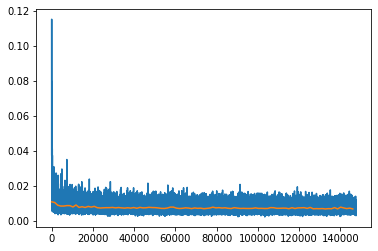

In [11]:
plt.plot(train_losses)
plt.plot(val_losses[:,0], val_losses[:,1])

In [71]:
# Training loop
batch_size = 100
n_epochs = 100
p_validation = 0.1

num_layers = 5
num_hidden = 64


# Define network, optimizer, and datasets
distance_net = DistanceEstimator(theta.shape[1], x.shape[1], num_layers, num_hidden, net_type='MLP')
nn_loss = nn.MSELoss()
optimizer = optim.Adam(distance_net.parameters())

###
# TRY PICKING THE N CLOSEST Xs to Xref FOR TRAINING
# OR USE LOG DISTANCE AS TRAINING SIGNAL
###

# splitting train and val
dataset = TensorDataset(idx_train)
train_set, val_set = torch.utils.data.random_split(dataset, (Tensor([1-p_validation, p_validation])*len(dataset)).to(int))
dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
theta_val, x_val, dist_val = idx_to_data(val_set[:], theta, x_target, dist_precomputed)

# go brrrrr
train_losses, val_losses = [], []
for e in range(n_epochs):
    for i_b, idx_batch in enumerate(dataloader):
        optimizer.zero_grad()
        
        # load batch of theta, x, and pre-computed distances
        theta_batch, x_batch, dist_batch = idx_to_data(idx_batch, theta, x_target, dist_precomputed)
        
        # forward pass for distances
        dist_pred = distance_net(theta_batch, x_batch).squeeze()
        
        # training loss
        l = nn_loss(dist_batch, dist_pred)
        l.backward()
        optimizer.step()        
        train_losses.append(l.detach())

    # compute validation loss    
    dist_pred = distance_net(theta_val, x_val).squeeze()
    l_val = nn_loss(dist_val, dist_pred)
    val_losses.append([i_b*e, l_val.detach()])

    if e%4==0:
        print(f"{e}: {l}")
        
train_losses = torch.Tensor(train_losses)
val_losses = torch.Tensor(val_losses)

0: 0.01099090650677681
4: 0.012702127918601036
8: 0.005508732050657272
12: 0.006999950390309095
16: 0.008072528056800365
20: 0.010759446769952774
24: 0.00773100508376956
28: 0.008323121815919876
32: 0.005504945293068886
36: 0.005787691101431847
40: 0.007153743878006935
44: 0.007668381556868553
48: 0.00550440838560462
52: 0.009919635020196438
56: 0.008960280567407608
60: 0.0062563540413975716
64: 0.014551937580108643
68: 0.006712727714329958
72: 0.006441923789680004
76: 0.007955485954880714
80: 0.007911661639809608
84: 0.0074511561542749405
88: 0.010890165343880653
92: 0.008411063812673092
96: 0.009308740496635437


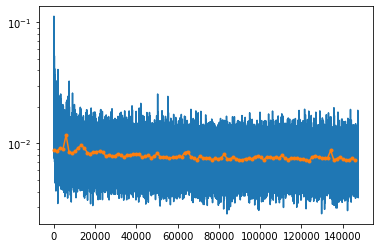

In [72]:
plt.plot(train_losses)
plt.plot(val_losses[:,0],val_losses[:,1], '.-')
plt.yscale('log')

In [15]:
# NPE
inference = SNPE(prior, density_estimator='nsf')
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 104 epochs.

In [16]:
# GBI
gll = build_amortized_GLL(distance_net)
gbi_potential = GBIPotential(prior, gll)

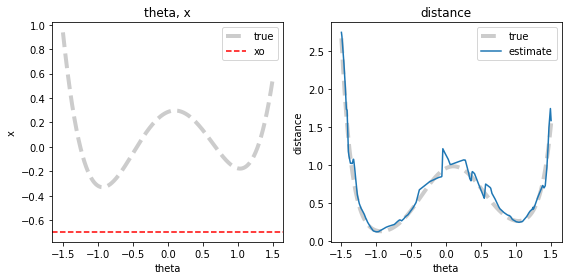

In [17]:
# evaluation
x_o = x_test[3] # 3

theta_grid = torch.linspace(-1.5,1.5,3001).unsqueeze(1)
x_grid = simulator(theta_grid, poly_coeffs, 0)

dist_grid = dist(x_grid.unsqueeze(1), x_o)
dist_pred = distance_net(theta_grid, x_o.repeat(theta_grid.shape))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(theta_grid, x_grid, 'k--', lw=4, alpha=0.2, label='true')
plt.axhline(x_o.squeeze(), color='r', ls='--', label='xo')
plt.title('theta, x'); plt.legend()
plt.xlabel('theta');plt.ylabel('x');

plt.subplot(1,2,2)
plt.plot(theta_grid, dist_grid, 'k--', lw=4, alpha=0.2, label='true')
plt.plot(theta_grid, dist_pred.detach(), '-', alpha=1, label='estimate')
plt.title('distance');plt.legend()
plt.xlabel('theta');plt.ylabel('distance');
plt.tight_layout()

In [22]:
n_posterior_samples = 200
beta = 50
gbi_potential.set_x(x_o)
gbi_potential.set_beta(beta)
gbi_sampler = MCMCPosterior(gbi_potential, prior)
gbi_samples = gbi_sampler.sample((n_posterior_samples,))

# npe samples
npe_samples = posterior.sample((n_posterior_samples,), x=x_o)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2100 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

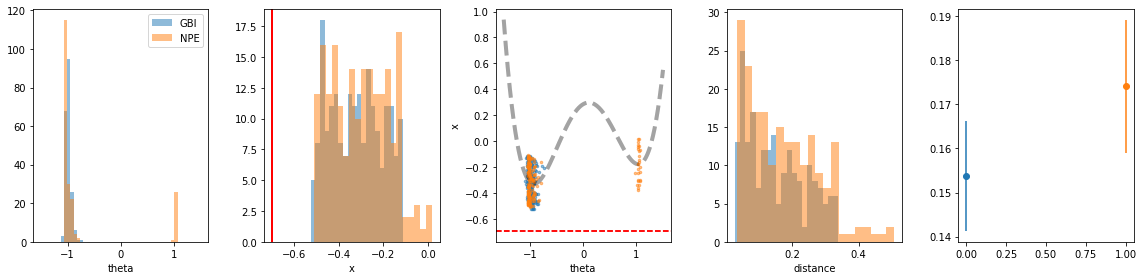

In [34]:
plt.figure(figsize=(16,4))

for i_p, posterior_samples in enumerate([gbi_samples, npe_samples]):
    plt.subplot(1,5,1)
    plt.hist(posterior_samples.numpy().squeeze(), np.linspace(-1.5,1.5,50), alpha=0.5);
    plt.xlabel('theta')

    post_pred = simulator(posterior_samples, poly_coeffs, noise_width)
    plt.subplot(1,5,2)
    plt.hist(post_pred.numpy().squeeze(), 20, alpha=0.5);
    plt.axvline(x_o.squeeze(), color='r', lw=2)
    plt.xlabel('x')
    
    plt.subplot(1,5,3)
    plt.plot(posterior_samples.squeeze(), post_pred.squeeze(), '.', alpha=0.5, ms=5)
    plt.plot(theta_grid, x_grid, 'k--', lw=4, alpha=0.2, label='true')
    plt.axhline(x_o.squeeze(), color='r', ls='--', label='xo')
    plt.xlabel('theta'); plt.ylabel('x'); 

    post_pred_dist = dist(post_pred.unsqueeze(1), x_o)
    plt.subplot(1,5,4)
    plt.hist(post_pred_dist.numpy().squeeze(), 20, alpha=0.5);
    # plt.axvline(x_o.squeeze(), color='r', lw=2)
    plt.xlabel('distance')
    
    plt.subplot(1,5,5)
    plt.errorbar(i_p, post_pred_dist.mean(), post_pred_dist.std()/np.sqrt(post_pred_dist.shape[0])*2, fmt='o') # mean +/- 2 sem

# theta_grid[np.abs(x_grid-x_o)<=(noise_width/2)];
plt.subplot(1,5,1)
plt.legend(['GBI', 'NPE'])
plt.tight_layout()

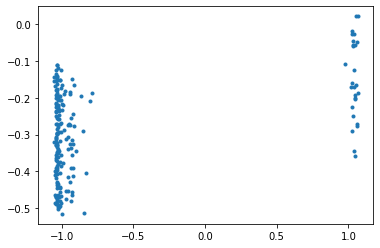

In [32]:
beta = 50.
gbi_potential.set_beta(beta)

all_posterior_samples = []
for i_x, x_o in enumerate(x_test):
    print(i_x)
    # GBI    
    gbi_potential.set_x(x_o)    
    gbi_sampler = MCMCPosterior(gbi_potential, prior)
    gbi_samples = gbi_sampler.sample((100,))

    # npe samples
    npe_samples = posterior.sample((100,), x=x_o)
    
    all_posterior_samples.append([gbi_samples, npe_samples])

0


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

6


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

7


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

8


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

9


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

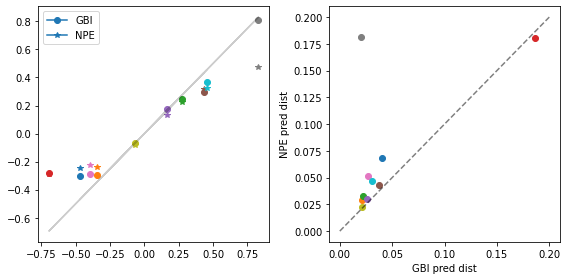

In [35]:
plt.figure(figsize=(8,4))
for i_p, pp in enumerate(all_posterior_samples):
    post_pred_dist = []
    for i_q, posterior_samples in enumerate(pp):
        plt.subplot(1,2,1)
        post_pred = simulator(posterior_samples, poly_coeffs, noise_width)
        plt.plot(x_test[i_p], post_pred.mean(), f'C{i_p}', marker='o' if i_q==0 else '*')        
        post_pred_dist.append(dist(post_pred.unsqueeze(1), x_test[i_p]))
        
    plt.subplot(1,2,2)
    plt.plot(post_pred_dist[0].mean(), post_pred_dist[1].mean(), f'oC{i_p}')
    # plt.errorbar(post_pred_dist[0].mean(), post_pred_dist[1].mean(), xerr=post_pred_dist[0].mean(), yerr=post_pred_dist[1].std(), color=f'C{i_p}')

plt.subplot(1,2,1)
plt.legend(['GBI', 'NPE'])
plt.plot(x_test, x_test, '-k', alpha=0.2)

plt.subplot(1,2,2)
plt.plot([0,0.2], [0,0.2], 'k--', alpha=0.5)
plt.xlabel('GBI pred dist'); plt.ylabel('NPE pred dist');
plt.tight_layout()

-------
scratch

In [6]:
import matplotlib.pyplot as plt
import torch
from torch import zeros, ones, nn, Tensor, optim
from torch.utils.data import TensorDataset, DataLoader
from sbi.utils.torchutils import atleast_2d
from sbi.utils import BoxUniform, likelihood_nn

# from sbi.utils.gbi import build_generalized_log_likelihood, GBIPotential, mse_dist
# from sbi.inference import MCMCPosterior, SNPE, DirectPosterior #SNLE, RejectionPosterior, likelihood_estimator_based_potential

from gbi import distances

import numpy as np
import sbibm

In [10]:
# class DistanceRegressionEstimator(nn.Module):
#     def __init__(self, theta_dim, x_dim, hidden_features, num_layers):
#         super().__init__()

#         input_dim = theta_dim + x_dim
#         output_dim = 1

#         layers = [nn.Linear(input_dim, hidden_features), nn.ReLU()]
#         for _ in range(num_layers - 1):
#             layers.append(nn.Linear(hidden_features, hidden_features))
#             layers.append(nn.ReLU())
            
#         layers.append(nn.Linear(hidden_features, output_dim))
#         self.net = nn.Sequential(*layers)
        
#     def forward(self, theta, x):
#         """
#         Predicts distance between theta and x
#         """        
#         return self.net(torch.concat((theta, x), dim=-1))

    
def build_amortized_GLL(
    distance_net: nn.Module,
    x_o: Tensor,
):
    def generalized_loglikelihood(thetas: Tensor):
        thetas = atleast_2d(thetas)
        # print('here')
        # print(x_o, thetas.shape)
        distances = distance_net(thetas, x_o.repeat((thetas.shape[0],1))).squeeze(1)
        # print(distances.shape, (thetas.shape[0],))
        assert distances.shape == (thetas.shape[0],)
        return distances

    return generalized_loglikelihood

In [16]:
dist = distances.mse_dist
n_samples = 500
_ = torch.manual_seed(0)

# simulate
theta = prior.sample((n_samples,))
x = simulator(theta)

# make "observations"
theta_obs = prior.sample((20,))
x_obs = simulator(theta_obs)

# make some misspecified examples
x_obs[10:] -= torch.randn(x_obs[10:].shape)
xs = torch.concat((x, x_obs), 0)

# compute distances
dists_precomp = torch.vstack([dist(x.unsqueeze(1), x_i) for x_i in xs]).T
idx_train = Tensor(np.indices((theta.shape[0],xs.shape[0])).reshape((2,-1)).T).to(int)

In [17]:
batch_size = 500
n_epochs = 10

dataset = TensorDataset(idx_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
distance_net = DistanceRegressionEstimator(theta.shape[1], x.shape[1], 64, 3)

nn_loss = nn.MSELoss()
optimizer = optim.Adam(distance_net.parameters())

losses = []
for e in range(n_epochs):
    for idx_batch in dataloader:
        optimizer.zero_grad()
        
        # load up the thetas, xs, and distances
        theta_batch, xs_batch = theta[idx_batch[0][:,0]], xs[idx_batch[0][:,1]]
        
        # look up from precomputed distance matrix
        dist_batch = dists_precomp[idx_batch[0][:,0], idx_batch[0][:,1]]
        
        # ... or compute on the spot
        
        
        # forward pass for distances
        dist_pred = distance_net(theta_batch, xs_batch).squeeze()
        

        l = nn_loss(dist_batch, dist_pred)
        l.backward()
        optimizer.step()        
        losses.append(l.detach())
    
    if e%1==0:
        print(f"{e}: {l}")

0: 0.004506419878453016
1: 0.0032810980919748545
2: 0.0037743255961686373
3: 0.003387430915609002
4: 0.004076655022799969
5: 0.0036874476354569197
6: 0.004670131951570511
7: 0.0036440142430365086
8: 0.0033230322878807783
9: 0.004466334357857704


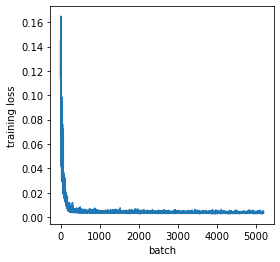

In [34]:
plt.figure(figsize=(4,4))
plt.plot(losses)
plt.xlabel('batch'); plt.ylabel('training loss');

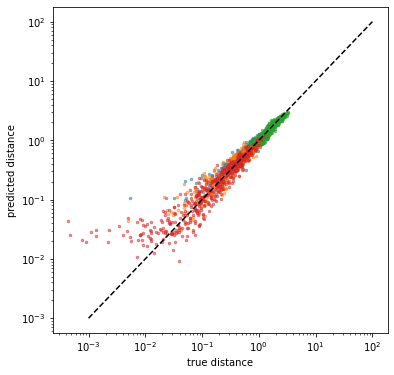

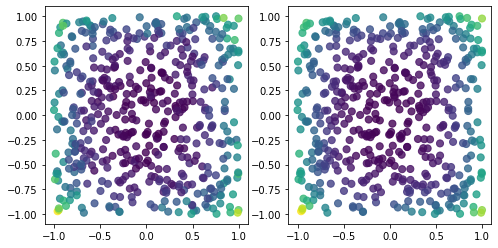

In [35]:
plt.figure(figsize=(6,6))
# x_o = x_obs[12,:]
for i_x, x_o in enumerate(x_obs[10:14]):
    dist_pred = distance_net(theta, x_o.repeat((theta.shape[0],1))).squeeze()
    dist_true = dist(x.unsqueeze(1), x_o)
    plt.loglog(dist_true, dist_pred.detach(), '.' if i_x<10 else '+', ms=5, alpha=0.5)

plt.plot([1e-3, 1e2], [1e-3,1e2], 'k--')
plt.xlabel('true distance'); plt.ylabel('predicted distance');


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(theta[:,0], theta[:,1], c=dist_true, s=50, alpha=0.8)
plt.subplot(1,2,2)
plt.scatter(theta[:,0], theta[:,1], c=dist_pred.detach(), s=50, alpha=0.8)


In [421]:
i_o = 1
x_o = x_obs[i_o]
theta_o = theta_obs[i_o]
dist_true = mse_dist(x.unsqueeze(1), x_o)

gll = build_amortized_GLL(distance_net, x_o)
gbi_potential = GBIPotential(prior, gll, beta=20.)
gbi_potential.set_x(x_o)
sampler = MCMCPosterior(gbi_potential, prior)

In [422]:
theta_posterior_samples = sampler.sample((100,))
theta_np = theta_posterior_samples.numpy()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

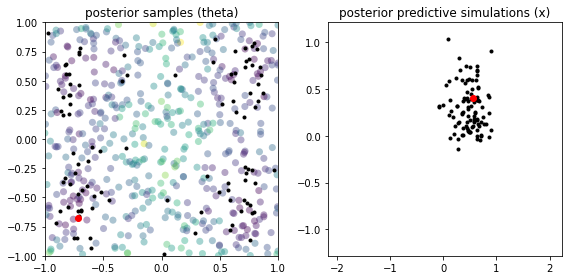

In [425]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(theta_np[:,0], theta_np[:,1], '.k')
plt.plot(theta_o[0],theta_o[1], 'or')
plt.scatter(theta[:,0], theta[:,1], c=dist_true, s=50, alpha=0.4, ec=None)
plt.xlim([-1,1]);plt.ylim([-1,1]);
plt.title('posterior samples (theta)')

plt.subplot(1,2,2)
x_pp = simulator(theta_posterior_samples)
plt.plot(x_pp[:,0], x_pp[:,1], 'k.')
plt.plot(x_o[0], x_o[1], 'ro')
plt.xlim(xs[:,0].min(), xs[:,0].max())
plt.ylim(xs[:,1].min(), xs[:,1].max())
plt.title('posterior predictive simulations (x)')
plt.tight_layout()

---
# 2-moons

In [428]:
def make_2d_grid(d1_bounds, d2_bounds, d1_res=100, d2_res=100):
    x1 = torch.linspace(*d1_bounds, d1_res)
    x2 = torch.linspace(*d2_bounds, d2_res)
    xs = torch.stack(torch.meshgrid(x1, x2))
    xs = torch.reshape(xs, (2, (d1_res)*(d2_res))).T
    dx = torch.diff(x1).mean()*torch.diff(x2).mean()
    return xs, dx

In [510]:
print(sbibm.get_available_tasks())

task_name =  "two_moons" # "gaussian mixture" has no likelihood
obs_num = 3

task = sbibm.get_task(task_name)
simulator = task.get_simulator()
log_prob_fn = task._likelihood
prior = task.get_prior()
x_o = task.get_observation(num_observation=obs_num)

x_grid, dx = make_2d_grid((-1.5,1.5), (-1.5, 1.5), 200,200)
th_res = (100, 100)
theta_grid, dth = make_2d_grid((-1,1), (-1,1), th_res[0], th_res[1])

['two_moons', 'gaussian_mixture', 'gaussian_linear', 'bernoulli_glm', 'gaussian_linear_uniform', 'slcp', 'sir', 'lotka_volterra', 'slcp_distractors', 'bernoulli_glm_raw']


In [511]:
_ = torch.manual_seed(0)

# simulate
theta = prior(5000,)
x = simulator(theta)

# make "observations"
theta_obs = prior(20,)
x_obs = simulator(theta_obs)

# make some misspecified examples
x_obs[10:] -= 0.5 #torch.randn(x_obs[10:].shape)
xs = torch.concat((x, x_obs), 0)

# compute distances
dists_precomp = torch.vstack([mse_dist(x.unsqueeze(1), x_i) for x_i in xs]).T
idx_train = Tensor(np.indices((theta.shape[0],xs.shape[0])).reshape((2,-1)).T).to(int)

In [ ]:
batch_size = 100
n_epochs = 20

dataset = TensorDataset(idx_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
distance_net = DistanceRegressionEstimator(theta.shape[1], x.shape[1], 64, 3)

nn_loss = nn.MSELoss()
optimizer = optim.Adam(distance_net.parameters())

losses = []
for e in range(n_epochs):
    for idx_batch in dataloader:
        optimizer.zero_grad()
        
        # load up the thetas, xs, and distances
        theta_batch, xs_batch = theta[idx_batch[0][:,0]], xs[idx_batch[0][:,1]]
        
        # look up from precomputed distance matrix
        dist_batch = dists_precomp[idx_batch[0][:,0], idx_batch[0][:,1]]
        
        # ... or compute on the spot
            
        # forward pass for distances
        dist_pred = distance_net(theta_batch, xs_batch).squeeze()
        

        l = nn_loss(dist_batch, dist_pred)
        l.backward()
        optimizer.step()        
        losses.append(l.detach())
    
    if e%1==0:
        print(f"{e}: {l}")

0: 0.0033566344063729048
1: 0.0044172839261591434
2: 0.004380556754767895
3: 0.004244915675371885
4: 0.0030074843671172857
5: 0.0034854754339903593


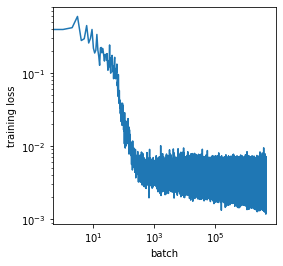

In [513]:
plt.figure(figsize=(4,4))
plt.loglog(losses)
plt.xlabel('batch'); plt.ylabel('training loss');

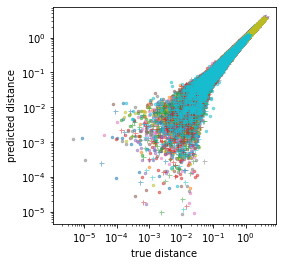

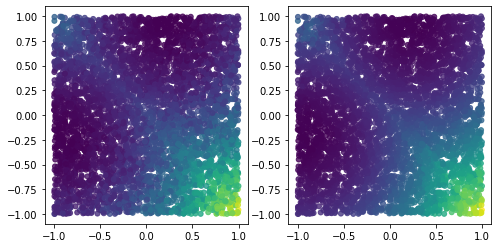

In [518]:
MS = 25
plt.figure(figsize=(4,4))

for i_x, x_o in enumerate(x_obs):
    dist_pred = distance_net(theta, x_o.repeat((theta.shape[0],1))).squeeze()
    dist_true = mse_dist(x.unsqueeze(1), x_o)
    plt.loglog(dist_true, dist_pred.detach(), '.' if i_x<10 else '+', ms=5, alpha=0.5)
    
plt.xlabel('true distance'); plt.ylabel('predicted distance');

x_o = x_obs[1,:]
dist_pred = distance_net(theta, x_o.repeat((theta.shape[0],1))).squeeze()
dist_true = mse_dist(x.unsqueeze(1), x_o)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(theta[:,0], theta[:,1], c=dist_true, s=MS, alpha=0.8)
plt.subplot(1,2,2)
plt.scatter(theta[:,0], theta[:,1], c=dist_pred.detach(), s=MS, alpha=0.8)

In [573]:
prior = BoxUniform(low=torch.Tensor((-1, -1)), high=torch.Tensor((1, 1)))

# train NPE for comparison
inference = SNPE(prior, 'nsf')
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 91 epochs.

In [565]:
# sample with GBI potential
i_o = 14
x_o = x_obs[i_o]
theta_o = theta_obs[i_o]
dist_true = mse_dist(x.unsqueeze(1), x_o)

In [566]:
gll = build_amortized_GLL(distance_net, x_o)
gbi_potential = GBIPotential(prior, gll, beta=200.)
gbi_potential.set_x(x_o)
sampler = MCMCPosterior(gbi_potential, prior)
theta_posterior_samples = sampler.sample((100,))
theta_np = theta_posterior_samples.numpy()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

In [570]:
npe_samples = posterior.sample((100,), x=x_o).numpy()

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 100 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


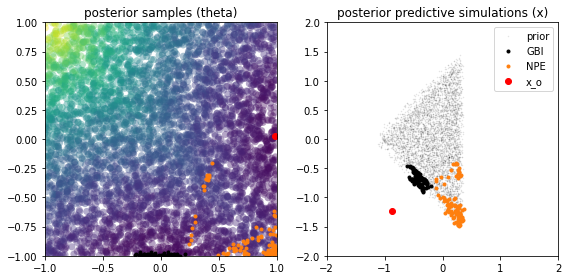

In [568]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(theta_np[:,0], theta_np[:,1], '.k')
plt.plot(npe_samples[:,0], npe_samples[:,1], '.C1')
plt.plot(theta_o[0],theta_o[1], 'or')
plt.scatter(theta[:,0], theta[:,1], c=dist_true, s=50, alpha=0.4, ec=None)
plt.xlim([-1,1]);plt.ylim([-1,1]);
plt.title('posterior samples (theta)')

plt.subplot(1,2,2)
x_pp = simulator(theta_posterior_samples)
x_npe = simulator(npe_samples)

plt.plot(x[:,0],x[:,1], '.k', alpha=0.1, ms=1, label='prior')
plt.plot(x_pp[:,0], x_pp[:,1], 'k.', label='GBI')
plt.plot(x_npe[:,0], x_npe[:,1], 'C1.', label='NPE')
plt.plot(x_o[0], x_o[1], 'ro', label='x_o')
plt.legend()
plt.xlim([-2,2]);plt.ylim([-2,2]);
# plt.xlim(xs[:,0].min(), xs[:,0].max())
# plt.ylim(xs[:,1].min(), xs[:,1].max())
plt.title('posterior predictive simulations (x)')
plt.tight_layout()

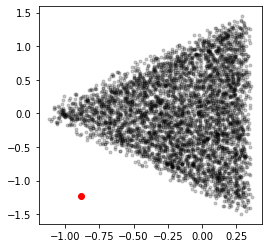

In [547]:
i_o = 14
x_o = x_obs[i_o]
plt.figure(figsize=(4,4))
plt.plot(x_o[0], x_o[1], 'ro')
plt.plot(x[:,0],x[:,1], '.k', alpha=0.2)